# Visualizing PSD, SCV and Specified Frequency distributions

Goal: Creating the tools with standalone callbacks 

Steps to complete the main tool:
1. set up changeable channels with the most basic barebone example
2. link the two plots together
3. link to the frequency slider (mind the javacall back: callback_policy="mouseup")
4. set up histogram and bin changer
5. link histogram data. make sure it can be updated
6. fix minor details such as plot labels etc.

In [1]:
import sys
# locate your spectralCV so we have scv_funcs to use
sys.path.append('/Users/ldliao/Research/Projects/spectralCA/')
sys.path.append('/Users/ldliao/Research/Projects/spectralCA/notebooks_visualization/')

sys.path.append('/Users/rdgao/Documents/code/research/spectralCA/')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCA/notebooks_visualization/')

In [2]:
import os
# the only lines you need to change to inspect different saved data
path = '/Users/ldliao/Research/Projects/spectralCA/results/kjm_digits/bp/'
# path = '/Users/ldliao/Research/Projects/spectralCA/results/nt/'
# path = '/Users/ldliao/Research/Projects/spectralCA/results/dino/'

# path = '/Users/rdgao/Documents/code/research/spectralCA/results/dino/'

os.chdir(path) # DONT CHANGE PATH INSIDE THE NOTEBOOK, YOU"LL GET LOST. USE FULL PATH
import glob
from sca import sca
import neurodsp as ndsp

# the final product to import the visualization
from sca import sca_vis

Loading BokehJS ...

In [3]:
# # need data
# import scipy.io as io
# import pandas as pd 
# import numpy as np

# data_path = "/Users/ldliao/Research/Data/Dino/Dino_072114_mPFC_ephys.mat"
# # data_path = "/Users/rdgao/Documents/data/CRCNS/fcx1/Dino_072114_mPFC/Dino_072114_mPFC_ephys.mat"
# dino = io.loadmat(data_path, squeeze_me=True)

# info_path = "/Users/ldliao/Research/Data/Dino/Dino_072114_mPFC_wakesleep.csv"
# # info_path = "/Users/rdgao/Documents/data/CRCNS/fcx1/Dino_072114_mPFC/Dino_072114_mPFC_wakesleep.csv"
# info = pd.read_csv(info_path,index_col='Unnamed: 0')

# label = 'Sleep'
# duration = list(zip(info[info['Label'] == label]['Start'].values, info[info['Label'] == label]['End'].values))
# fs = 1250
# analysis_param = {'nperseg': int(fs),
#                  'noverlap': 0,
#                  'spg_outlierpct': 4.,
#                  'max_freq':200}

# data = []
# for dur in duration:
#     start, end = dur
    
#     # don't append like this because there will be a gap if there are multiple trials
#     # of the same type. Compute sca separately
#     data.append(dino['lfp'][:,start*fs:end*fs])
    
# data = np.column_stack(data)

# # need data
# sc = sca.SCA(analysis_param)
# sc.populate_ts_data(data, fs)
# sc.compute_all_spectral()
# sc.compute_KS_expfit()

# chan_count, freq = sc.psd.shape
# chan_labels = list(map(str, range(chan_count)))
# sc.chan_labels = ['chan_'+chan for chan in chan_labels]

In [ ]:
# sc = sca.sca_load_spec('nt_sca2_Anes.npz')
# sc = sca.sca_load_spec('sleep.npz')
sc = sca.sca_load_spec('wake.npz')

In [ ]:
sca_vis.plot_pct_spectrogram(sc=sc, show_pct_ex=False)

In [ ]:
# ignore bokeh warnings
import warnings
warnings.filterwarnings('ignore')
sca_vis.plot_vis(sc=sc, plot_complex=True)

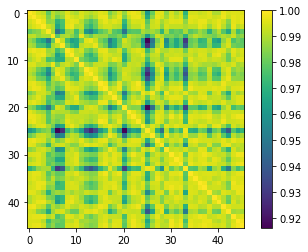

In [10]:
# import matplotlib.pyplot as plt
# sc = sca.sca_load_spec('move.npz')
# sc.cross_freq_corr()
# plt.imshow(sc.pow_corrmat)
# plt.colorbar()
# plt.show()

### Imports

In [ ]:
# imports
import numpy as np
import scipy as sp
from scipy.stats import expon
from scipy.stats import pearsonr
import glob

# import neurodsp as ndsp
# from scv_funcs import lfpca
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# chan_num, freq_num = sc.psd.shape
# pow_corrmat = np.zeros((chan_num, chan_num))
# pow_pvmat = np.zeros((chan_num, chan_num))
# for row_chan in range(chan_num):
#     for col_chan in range(chan_num):
#         pow_corrmat[row_chan][col_chan], pow_pvmat[row_chan][col_chan] = pearsonr(np.log(sc.psd)[row_chan], np.log(sc.psd)[col_chan])

In [ ]:
# bokeh imports
import bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, Slider, Span, Title
from bokeh.models.widgets import Select, Slider
from ipywidgets import Layout, HBox, interactive
import matplotlib.pyplot as plt

import ipywidgets as widgets

from bokeh.palettes import viridis
from bokeh.models.glyphs import Rect
from bokeh.models import BoxAnnotation

output_notebook()

### Defaults

In [ ]:
# setting up the defaults
chan = 1
select_freq = 10
select_bin = 20

freq_vals = sc.f_axis[1:]
psd_vals = sc.psd[chan].T[1:]
scv_vals = sc.scv[chan].T[1:]
real_vals = sc.spg.real[chan][select_freq]
imag_vals = sc.spg.imag[chan][select_freq]

source = ColumnDataSource(data=dict(freq_vals=freq_vals, 
                                    psd_vals=psd_vals, 
                                    scv_vals=scv_vals))

complex_source = ColumnDataSource(data=dict(real_vals=real_vals, imag_vals=imag_vals))

# set channel labels
DEFAULT_TICKERS = sc.chan_labels

In [ ]:
# # set up complex plot
# complex_plot = figure(title='Complex SPG', plot_width=300, plot_height=300)
# complex_plot.legend.location = 'top_left'
# complex_plot.xaxis.axis_label = 'Real values'
# complex_plot.yaxis.axis_label = 'Imaginary values'
# complex_plot.grid.grid_line_alpha=0.3
# complex_plot.circle('real_vals', 'imag_vals', size=5, color="purple", alpha=0.5, source=complex_source)

# # create interact
# def update_spct(channel=1, f=10):    
#     plot_chan = int(channel)
#     plot_freq = np.where(sc.f_axis==f)[0][0]

#     # update complex data
#     complex_source.data['real_vals'] = sc.spg.real[plot_chan][plot_freq]
#     complex_source.data['imag_vals'] = sc.spg.imag[plot_chan][plot_freq]
    
#     push_notebook()
    
# show(complex_plot, notebook_handle=True)
    
# warnings.filterwarnings('ignore')
# widget = interactive(update_spct, channel=range(1,len(DEFAULT_TICKERS)-1), f=(1,199), numbins=(10,55,5))
# items = [kid for kid in widget.children]
# display(HBox(children=items))

### Sliders and updates

In [ ]:
# create interact
def update_spct(channel=DEFAULT_TICKERS[0], f=10, numbins=20):
    channel = int(channel.split('_')[1])
    plot_chan = int(channel)
    plot_freq = np.where(sc.f_axis==f)[0][0]
    y, x = np.histogram(abs(sc.spg[plot_chan,plot_freq,:])**2, bins=numbins, density=True)

    # create a column data source for the plots to share
    data_source = {
                   'freq_vals': sc.f_axis[1:],
                   'psd_vals': sc.psd[plot_chan].T[1:],
                   'scv_vals': sc.scv[plot_chan].T[1:]
                   }   
    source.data = data_source
    vline_psd.location = f
    vline_scv.location = f
    # update histogram with data from frequency f
    hist_plot.data_source.data['left'] = x[:-1]
    hist_plot.data_source.data['right'] = x[1:]
    hist_plot.data_source.data['top'] = y    
    
    # update fitted
    rv = expon(scale=sp.stats.expon.fit(abs(sc.spg[plot_chan,plot_freq,:])**2,floc=0)[1])
    fit_plot.data_source.data['x'] = x
    fit_plot.data_source.data['y'] = rv.pdf(x)

    # update complex data
    complex_source.data['real_vals'] = sc.spg.real[plot_chan][f]
    complex_source.data['imag_vals'] = sc.spg.imag[plot_chan][f]

    hist_fig.title.text = 'Freq = %.1fHz, p-value = %.4f'%(f, sc.ks_pvals[int(plot_chan), f])
    push_notebook()

### Set up the plots

### PSD, SCV, Hist, 2D complex

In [ ]:
sc = sca.sca_load_spec('wake.npz')
plot_side_length = 310
plot_complex = False

# set up histogram
y, x = np.histogram(abs(sc.spg**2)[0,10,:], bins=20, density=True)
hist_fig = figure(plot_height=plot_side_length, plot_width=plot_side_length, x_axis_label='Power', y_axis_label='Probability')
hist_plot = hist_fig.quad(top=y, bottom=0, left=x[:-1], right=x[1:], fill_color='purple', line_color="lightblue")
hist_fig.title.text = 'Freq = %.1fHz, p-value = %.4f'%(10, sc.ks_pvals[int(1), 10])
hist_fig.axis.major_label_text_font_size= '0pt'
fit_plot = hist_fig.line(x[:-1],y, line_width=8,alpha=0.7,line_color="#D53B54",legend='Fit PDF')

# set up psd plot
psd_plot = figure(title='PSD', x_axis_type='log', y_axis_type='log', plot_width=plot_side_length, plot_height=plot_side_length)
psd_plot.legend.location = 'top_left'
psd_plot.xaxis.axis_label = 'Frequency (Hz)'
psd_plot.yaxis.axis_label = 'Power/Frequency (dB/Hz)'
psd_plot.grid.grid_line_alpha=0.3
psd_plot.line('freq_vals', 'psd_vals', source=source)    

# set up scv plot
scv_plot = figure(title='SCV', x_axis_type='log', y_axis_type='log', plot_width=plot_side_length, plot_height=plot_side_length)
scv_plot.legend.location='top_left'
scv_plot.xaxis.axis_label = 'Frequency (Hz)'
scv_plot.yaxis.axis_label = '(Unitless)'
scv_plot.grid.grid_line_alpha=0.3
fit_line = bokeh.models.glyphs.Line(x='freq_vals', y=1, line_width=5, line_alpha=0.5, line_color='darkgrey')
scv_plot.add_glyph(source, fit_line)
scv_plot.line('freq_vals', 'scv_vals', source=source, color='navy')


# add in frequency slider vertical lines
vline_psd = Span(location=select_freq, dimension='height', line_color='red', line_dash='dashed', line_width=3)
vline_scv = Span(location=select_freq, dimension='height', line_color='red', line_dash='dashed', line_width=3)
psd_plot.add_layout(vline_psd)
scv_plot.add_layout(vline_scv)

if plot_complex:
    # set up complex plot
    complex_plot = figure(title='Complex SPG', plot_width=plot_side_length, plot_height=plot_side_length)
    complex_plot.legend.location = 'top_left'
    complex_plot.xaxis.axis_label = 'Real values'
    complex_plot.yaxis.axis_label = 'Imaginary values'
    basic_xline = bokeh.models.glyphs.Line(x='real_vals', y=0, line_width=5, line_alpha=0.5, line_color='darkgrey')
    complex_plot.add_glyph(complex_source, basic_xline)
    basic_yline = bokeh.models.glyphs.Line(x=0, y='imag_vals', line_width=5, line_alpha=0.5, line_color='darkgrey')
    complex_plot.add_glyph(complex_source, basic_yline)
    complex_plot.grid.grid_line_alpha=0.3
    complex_plot.circle('real_vals', 'imag_vals', size=5, color="purple", alpha=0.5, source=complex_source)
    # set up layout and interact tools
    layout = column(row(psd_plot, scv_plot), row(hist_fig, complex_plot))
    show(layout, notebook_handle=True)
else:
    # set up layout and interact tools
    layout = row(psd_plot, scv_plot, hist_fig)
    show(layout, notebook_handle=True)


warnings.filterwarnings('ignore')
widget = interactive(update_spct, channel=DEFAULT_TICKERS, f=(1,199), numbins=(10,55,5))
items = [kid for kid in widget.children]
display(HBox(children=items))

### Percentile Spectrogram

In [ ]:
def percentile_spectrogram(spg, f_axis, rank_freqs=(8., 12.), pct=(0, 25, 50, 75), sum_log_power=True, show=True):
    f_ind = np.where(np.logical_and(
        f_axis >= rank_freqs[0], f_axis <= rank_freqs[1]))

    if sum_log_power:
        power_vals = np.sum(np.log10(spg[f_ind, :][0]), axis=0)
    else:
        power_vals = np.sum(spg[f_ind, :][0], axis=0)

    bins = np.percentile(power_vals, q=pct)
    power_dgt = np.digitize(power_vals, bins, right=False)
    power_binned = np.asarray(
        [np.mean(spg[:, power_dgt == i], axis=1) for i in np.unique(power_dgt)])
    
    return power_dgt, power_binned

In [ ]:
# initializations
chan = 0
rank_freqs = (8,12)
pct_step = 25
plot_side_length = 350

# create interact
def update_pct_spct(channel=1, rank_freqs=(8,12), pct_step=25):   

    # updating information based on sliders
    channel = int(channel.split('_')[1])
    plot_chan = int(channel)
    pct_range = range(0,100,pct_step)
    power_dgt, power_binned = percentile_spectrogram(np.abs(sc.spg[plot_chan,:,:])**2, sc.f_axis, rank_freqs, pct_range);
    numlines = power_binned.T[1:].shape[1]
    freq_vals = [sc.f_axis[1:]]*numlines
    power = list(zip(*power_binned.T[1:].tolist()))

    palette = viridis(numlines)

    # create a column data source for the plots to share
    updated_source = dict(freq_vals=freq_vals, power=power, color=palette)

    source.data = updated_source

#     grid. = plot_grid(plot_chan, power_dgt, rank_freqs, N_to_plot=3)
    
    # update box position
    bg_box.left = rank_freqs[0]
    bg_box.right = rank_freqs[1]
    
    if pct_step == 25 or pct_step == 30:
        power_dgt, power_binned = percentile_spectrogram(np.abs(sc.spg[plot_chan,:,:]**2), sc.f_axis, rank_freqs, pct_range);
        pwr_ex = power_examples(sc.data[plot_chan,:], sc.fs, sc.t_axis, power_dgt, rank_freqs)
        pwr_ex_source.data = pwr_ex
        push_notebook()
    
    push_notebook()
    
def power_examples(data, fs, t_spg, pwr_dgt, rank_freqs):
    plot_t=1.
    ymin, ymax = 0, 0
    N_cycles=5
    power_adj=5
    
    # filter data and multiplier power constant for ease of visualization
    if power_adj:
        data_filt = ndsp.filt.filter_signal(
            data, fs, 'bandpass', f_range=rank_freqs, n_cycles=N_cycles) * power_adj

    plot_len = int(plot_t*fs/2)
    t_plot = np.arange(-plot_len, plot_len) / fs
    
    pwr_ex = {}
    # loop through bins
    for ind, j in enumerate(np.unique(pwr_dgt)):
        # grab a random window of data that fell within the current power bin
        plot_ind = int(t_spg[np.where(pwr_dgt == j)[0]][np.random.choice(
            len(np.where(pwr_dgt == j)[0]))] * fs)
        y = data[plot_ind - plot_len:plot_ind + plot_len]
        pwr_ex['raw_y' + str(ind+1)] = y - y.mean()
        pwr_ex['filt_y'+ str(ind+1)] = data_filt[plot_ind - plot_len:plot_ind + plot_len]

    pwr_ex['t_plot'] = t_plot
    
    return pwr_ex   

# calculating the percentile spectrogram
pct_range = range(0,100,pct_step)
power_dgt, power_binned = percentile_spectrogram(np.abs(sc.spg[chan,:,:]**2), sc.f_axis, rank_freqs, pct_range);
numlines = power_binned.T[1:].shape[1]
freq_vals = [sc.f_axis[1:]]*numlines
power = list(zip(*power_binned.T[1:].tolist()))

# color it accordingly
palette = viridis(numlines)

# filling in data
DEFAULT_TICKERS = sc.chan_labels

source = ColumnDataSource(data=dict(freq_vals=freq_vals, 
                                    power=power,
                                    color=palette))

# set up plot
pct_spct_plot = figure(title='Percentile Spectrogram', x_axis_type='log', y_axis_type='log', 
                       plot_width=plot_side_length, plot_height=plot_side_length)
pct_spct_plot.legend.location = 'top_left'

# plotting the box
bg_box = BoxAnnotation(left=rank_freqs[0], right=rank_freqs[1], fill_color='grey', fill_alpha=0.2, line_alpha=0)
pct_spct_plot.add_layout(bg_box)

# plotting the multi line
pct_spct_plot.multi_line(xs='freq_vals', ys='power', color='color', source=source)

# power examples from the raw data
power_dgt, power_binned = percentile_spectrogram(np.abs(sc.spg[chan,:,:]**2), sc.f_axis, rank_freqs, pct_range);
pwr_ex = power_examples(sc.data[chan,:], sc.fs, sc.t_axis, power_dgt, rank_freqs)
pwr_ex_source = ColumnDataSource(data=pwr_ex)

# set up plots
row_layout = row()

# looping through each Q
for ind, j in enumerate(np.unique(power_dgt)):
    plot_side_length = 300
    plot = figure(plot_width=int(plot_side_length*2/3), plot_height=int(plot_side_length/3), name='Q'+str(ind+1))
    plot.legend.location = 'top_left'
    plot.yaxis.ticker = [0]
    plot.grid.grid_line_alpha=0.3
    plot.line('t_plot', 'raw_y'+str(ind+1), source=pwr_ex_source, color=palette[ind])
    plot.line('t_plot', 'filt_y'+str(ind+1), source=pwr_ex_source, line_alpha=0.5, color=palette[ind])
    plot.add_layout(Title(text='Q'+str(ind+1), align='center'), 'above')
    row_layout.children.append(plot)
    
show(column(pct_spct_plot, row_layout), notebook_handle=True)

# defining the widge we are using
widget = interactive(update_pct_spct, channel=range(1,len(DEFAULT_TICKERS)+1), 
                                 rank_freqs=widgets.IntRangeSlider(
                                            value=[8, 12],
                                            min=1,
                                            max=199,
                                            step=1,
                                            description='rank_freqs',
                                            disabled=False,
                                            continuous_update=False,
                                            orientation='horizontal',
                                            readout=True,
                                            readout_format='d',
                                        ), pct_step=(5,100,5))
items = [kid for kid in widget.children]
display(HBox(children=items))

### Power examples

In [ ]:
import scipy.io as io
import pandas as pd 
import numpy as np

data_path = "/Users/ldliao/Research/Data/Dino/Dino_072114_mPFC_ephys.mat"
# data_path = "/Users/rdgao/Documents/data/CRCNS/fcx1/Dino_072114_mPFC/Dino_072114_mPFC_ephys.mat"
dino = io.loadmat(data_path, squeeze_me=True)

info_path = "/Users/ldliao/Research/Data/Dino/Dino_072114_mPFC_wakesleep.csv"
# info_path = "/Users/rdgao/Documents/data/CRCNS/fcx1/Dino_072114_mPFC/Dino_072114_mPFC_wakesleep.csv"
info = pd.read_csv(info_path,index_col='Unnamed: 0')

label = 'Sleep'
duration = list(zip(info[info['Label'] == label]['Start'].values, info[info['Label'] == label]['End'].values))
fs = 1250
analysis_param = {'nperseg': int(fs),
                 'noverlap': 0,
                 'spg_outlierpct': 4.,
                 'max_freq':200}

data = []
for dur in duration:
    start, end = dur
    
    # don't append like this because there will be a gap if there are multiple trials
    # of the same type. Compute sca separately
    data.append(dino['lfp'][:,start*fs:end*fs])
    
data = np.column_stack(data)

# need data
sc = sca.SCA(analysis_param)
sc.populate_ts_data(data, fs)
sc.compute_all_spectral()

In [ ]:
def power_examples(data, fs, t_spg, pwr_dgt, rank_freqs):
    plot_t=1.
    CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']  # grab color rota
    ymin, ymax = 0, 0
    N_cycles=5
    power_adj=5
    
    # filter data and multiplier power constant for ease of visualization
    if power_adj:
        data_filt = ndsp.filt.filter_signal(
            data, fs, 'bandpass', f_range=rank_freqs, n_cycles=N_cycles) * power_adj

    plot_len = int(plot_t*fs/2)
    t_plot = np.arange(-plot_len, plot_len) / fs
    
    pwr_ex = {}
    color_list = []
    # loop through bins
    for ind, j in enumerate(np.unique(pwr_dgt)):
        # grab a random window of data that fell within the current power bin
        plot_ind = int(t_spg[np.where(pwr_dgt == j)[0]][np.random.choice(
            len(np.where(pwr_dgt == j)[0]))] * fs)
        y = data[plot_ind - plot_len:plot_ind + plot_len]
        pwr_ex['raw_y' + str(ind+1)] = y - y.mean()
        color_list.append(CKEYS[j - 1])
        pwr_ex['filt_y'+ str(ind+1)] = data_filt[plot_ind - plot_len:plot_ind + plot_len]

    pwr_ex['t_plot'] = t_plot
    
    return pwr_ex, color_list

In [ ]:
# # %time
# from bokeh.models import Title
# from bokeh.layouts import gridplot, row, column


# def plot_row(source, chan, color, power_dgt, rank_freqs, N_to_plot=3, plot_side_length=300):
#     row_plots = []
#     for ind, j in enumerate(np.unique(power_dgt)):
#         plot = figure(plot_width=int(plot_side_length*2/3), plot_height=int(plot_side_length/3))
#         plot.legend.location = 'top_left'
#         plot.yaxis.ticker = [0]
#         plot.grid.grid_line_alpha=0.3
#         plot.line('t_plot', 'raw_y'+str(ind+1), source=source, color=color[ind])
#         plot.line('t_plot', 'filt_y'+str(ind+1), source=source, line_alpha=0.5, color=color[ind])
#         plot.add_layout(Title(text='Q' + str(ind+1), align='center'), 'above')
#         row_plots.append(plot)
#     return row_plots

In [ ]:
# chan_count, freq = sc.psd.shape

# DEFAULT_TICKERS = list(map(str, range(chan_count)))
# rank_freqs = (8,12)
# pct_step = 25
# pct_range = range(0,100,pct_step)
# chan = 1
# power_dgt, power_binned = percentile_spectrogram(np.abs(sc.spg[chan,:,:]**2), sc.f_axis, rank_freqs, pct_range);
# pwr_ex, color = power_examples(sc.data[chan,:], sc.fs, sc.t_axis, power_dgt, rank_freqs)

# source = ColumnDataSource(data=pwr_ex)

# row_layout = row()

# power_dgt, power_binned = percentile_spectrogram(np.abs(sc.spg[chan,:,:]**2), sc.f_axis, rank_freqs, pct_range);
# pwr_ex, color = power_examples(sc.data[chan,:], sc.fs, sc.t_axis, power_dgt, rank_freqs)
# for ind, j in enumerate(np.unique(power_dgt)):
#     plot_side_length = 300
#     plot = figure(plot_width=int(plot_side_length*2/3), plot_height=int(plot_side_length/3), name='Q'+str(ind+1))
#     plot.legend.location = 'top_left'
#     plot.yaxis.ticker = [0]
#     plot.grid.grid_line_alpha=0.3
#     plot.line('t_plot', 'raw_y'+str(ind+1), source=source, color=color[ind])
#     plot.line('t_plot', 'filt_y'+str(ind+1), source=source, line_alpha=0.5, color=color[ind])
#     plot.add_layout(Title(text='Q'+str(ind+1), align='center'), 'above')
#     row_layout.children.append(plot)

# def update_plot(channel=1):    
#     plot_chan = int(channel-1)
#     power_dgt, power_binned = percentile_spectrogram(np.abs(sc.spg[plot_chan,:,:]**2), sc.f_axis, rank_freqs, pct_range);
#     pwr_ex, color = power_examples(sc.data[plot_chan,:], sc.fs, sc.t_axis, power_dgt, rank_freqs)
#     source.data = pwr_ex
#     push_notebook()

# # warnings.filterwarnings('ignore')

# show(row_layout, notebook_handle=True)
# widget = interactive(update_plot, channel=range(1,len(DEFAULT_TICKERS)+1))
# items = [kid for kid in widget.children]
# display(HBox(children=items))